# Evaluation of stickiness model

Figures 3, 4 & 8 in the paper.

In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pickle

from impatient_bandits import StickinessHelper, ProgressiveBelief

In [2]:
# Training set.
with open("data/synthetic-data-train.pkl", "rb") as f:
    raw = pickle.load(f)

data_train = {k: v.astype(float) for k, v in raw.items()}
helper = StickinessHelper.from_data(data_train)

## Variance explained

In [3]:
def var_explained(cmat):
    remvar = np.zeros(len(cmat) - 1)  # Remaining variance
    for i in range(len(cmat) - 1):
        b = np.sum(cmat[: i + 1, : i + 1])
        a = np.sum(cmat[i + 1 :, i + 1 :])
        c = np.sum(cmat[i + 1 :, : i + 1])
        remvar[i] = a - c * c / b
    with_corr = 1.0 - (remvar / np.sum(cmat))
    with_corr = np.insert(with_corr, 0, 0)
    # Without correlation structure.
    wo_corr = np.cumsum(np.diag(cmat))[:-1] / np.sum(np.diag(cmat))
    wo_corr = np.insert(wo_corr, 0, 0)
    return with_corr, wo_corr

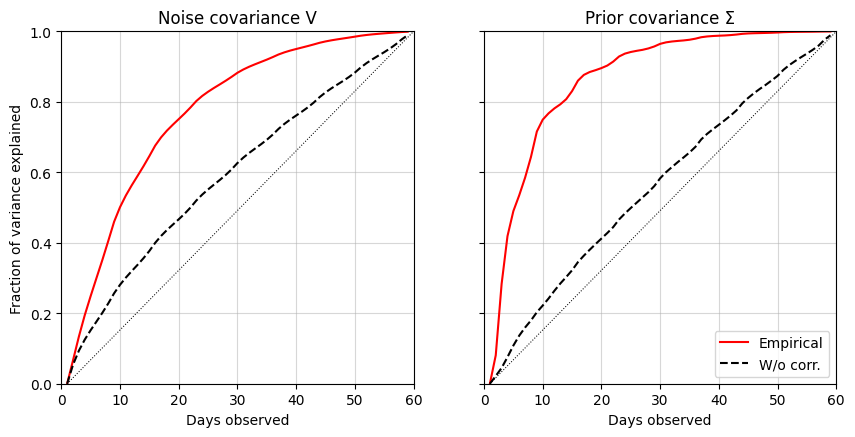

In [4]:
fig, axs = plt.subplots(
    ncols=2, sharey=True, figsize=(10, 5), subplot_kw={"box_aspect": 1}
)

xs = np.arange(1, 60)
for ax, title, cmat in (
    (axs[0], "Noise covariance V", helper.noise_cmat),
    (axs[1], "Prior covariance Σ", helper.prior_cmat),
):
    ys1, ys2 = var_explained(cmat)
    ax.plot(xs, ys1, color="red", label="Empirical")
    ax.plot(xs, ys2, ls="--", color="k", label="W/o corr.")
    ax.set_ylim(ymin=0, ymax=1)
    ax.set_xlim(xmin=0, xmax=60)
    ax.plot([1, 60], [0, 1], lw=0.75, ls=":", color="k")
    ax.grid(lw=0.8, alpha=0.5)
    ax.set_xlabel("Days observed")
    ax.set_title(title)

axs[0].set_ylabel("Fraction of variance explained")
axs[1].legend(frameon=True);

## Predictive performance

In [5]:
# Test set.
with open("data/synthetic-data-eval.pkl", "rb") as f:
    raw = pickle.load(f)

data_test = {k: v.astype(float) for k, v in itertools.islice(raw.items(), 200)}

In [6]:
rng = np.random.default_rng(seed=0)

ts = np.arange(0, 61, step=5)  # Days observed.
ms = (10, 100, 1000)  # Number of traces.
res = np.zeros((len(data_test), len(ms), len(ts)))
for i, traces in enumerate(data_test.values()):
    rng.shuffle(traces)
    train = traces[:1000]
    gt = np.mean(np.sum(traces[1000:], axis=1))
    for j, m in enumerate(ms):
        belief = ProgressiveBelief(
            helper.prior_mvec, helper.prior_cmat, helper.noise_cmat
        )
        belief.update(traces[:m], t=0)
        for k, t in enumerate(ts):
            belief.compute_posterior(t)
            res[i, j, k] = belief.mean - gt

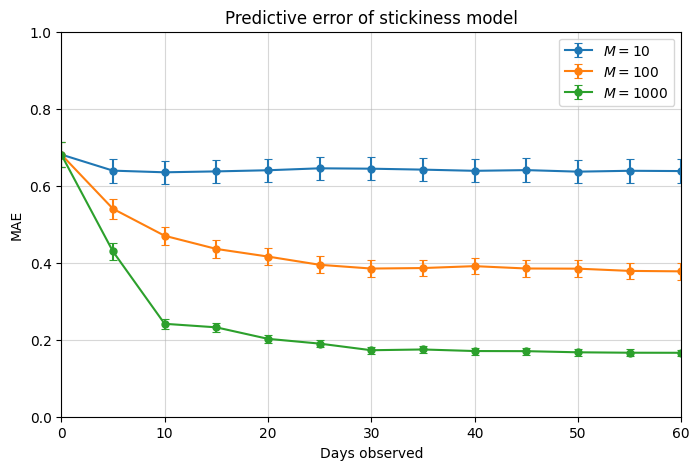

In [7]:
fig, ax = plt.subplots(figsize=(8, 5))

mae = np.mean(np.abs(res), axis=0)
ste = np.std(np.abs(res), axis=0) / np.sqrt(len(res))

for i, m in enumerate(ms):
    _, caps, _ = ax.errorbar(
        ts,
        mae[i],
        yerr=ste[i],
        marker="o",
        ms=5,
        capsize=3.0,
        #elinewidth=0.8,
        label=f"$M = {m}$",
    )
    [cap.set_markeredgewidth(0.8) for cap in caps]
ax.grid(lw=0.8, alpha=0.5)
ax.set_ylim(ymin=0, ymax=1.0)
ax.set_xlim(xmin=0, xmax=60)
ax.legend(frameon=True)
ax.set_title("Predictive error of stickiness model")
ax.set_xlabel("Days observed")
ax.set_ylabel("MAE");

## Covariance matrices

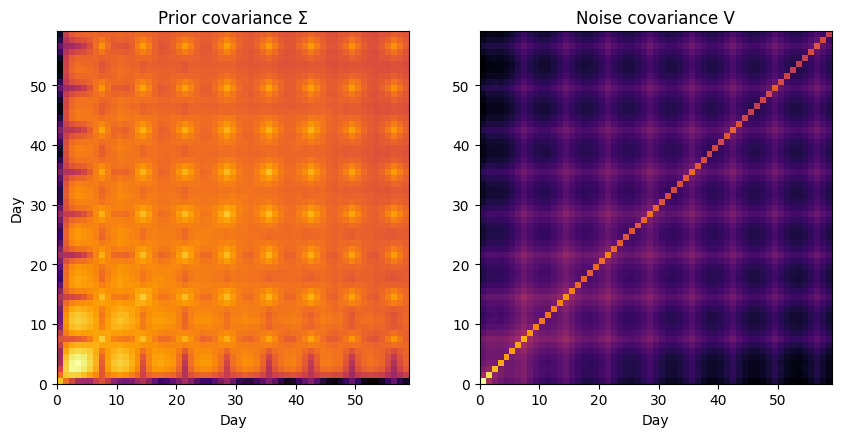

In [8]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5), subplot_kw={"aspect": "equal"})

ticks = np.arange(0, 60, step=10)
for ax, title, cmat in (
    (axs[0], "Prior covariance Σ", helper.prior_cmat),
    (axs[1], "Noise covariance V", helper.noise_cmat),
):
    ax.pcolormesh(np.log(cmat), cmap="inferno", rasterized=True)
    ax.set_xticks(ticks)
    ax.set_title(title)
    ax.set_xlabel("Day")
axs[0].set_ylabel("Day");